## Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import time
from scripts.function_utils import last_energy_points, predict_results, prepare_polynomial, normalize_training, split_train_test_timeseries, retrieve_selected_features

## Load Data

In [2]:
df = pd.read_csv("../../data/loureiro_40casas.csv")
number_of_houses = len(df.columns)
df

,Time,Energy_1,Energy_2,Energy_9,Energy_15,Energy_16,Energy_17,Energy_30,Energy_35,Energy_48,...,Energy_138,Energy_139,Energy_142,Energy_146,Energy_148,Energy_151,Energy_159,Energy_160,Energy_161,Energy_164
0,2022-05-05 12:00:00,0.068,0.018,0.024,0.164,0.072,0.055,0.006,0.080,0.062,...,0.052,0.083,0.084,0.068,0.060,0.042,0.055,0.069,0.010,0.004
1,2022-05-05 12:15:00,0.070,0.018,0.024,0.135,0.058,0.060,0.006,0.056,0.062,...,0.052,0.053,0.004,0.048,0.078,0.053,0.055,0.063,0.010,0.003
2,2022-05-05 12:30:00,0.122,0.018,0.024,0.121,0.011,0.096,0.006,0.052,0.062,...,0.052,0.035,0.004,0.062,0.061,0.057,0.055,0.049,0.010,0.004
3,2022-05-05 12:45:00,0.132,0.018,0.024,0.138,0.010,0.064,0.006,0.052,0.062,...,0.052,0.082,0.004,0.056,0.125,0.034,0.055,0.097,0.010,0.004
4,2022-05-05 13:00:00,0.125,0.018,0.024,0.104,0.011,0.072,0.006,0.053,0.062,...,0.052,0.076,0.004,0.034,0.070,0.038,0.055,0.075,0.010,0.004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38014,2023-06-07 01:15:00,0.120,0.020,0.066,0.120,0.003,0.094,0.037,0.045,0.071,...,0.047,0.054,0.004,0.080,0.014,0.028,0.066,0.058,0.000,0.003
38015,2023-06-07 01:30:00,0.121,0.004,0.057,0.087,0.002,0.077,0.036,0.046,0.059,...,0.051,0.038,0.004,0.060,0.028,0.023,0.067,0.032,0.016,0.004
38016,2023-06-07 01:45:00,0.158,0.007,0.056,0.086,0.003,0.087,0.021,0.045,0.059,...,0.068,0.045,0.004,0.057,0.029,0.043,0.065,0.495,0.008,0.003
38017,2023-06-07 02:00:00,0.102,0.042,0.056,0.085,0.002,0.072,0.027,0.045,0.059,...,0.067,0.053,0.003,0.061,0.012,0.047,0.041,0.274,0.000,0.004


In [3]:
df_total = pd.DataFrame(df.sum(axis=1))
df_total.columns = ['Energy']
df_total

,Energy
0,2.955
1,2.652
2,2.593
3,2.691
4,2.685
...,...
38014,1.820
38015,1.751
38016,2.252
38017,2.034


#### Example of past timesteps

In [4]:
Xt, yt = last_energy_points(df_total, 3)
Xt

,lag_15,lag_30,lag_45
0,2.593,2.652,2.955
1,2.691,2.593,2.652
2,2.685,2.691,2.593
3,3.438,2.685,2.691
4,2.769,3.438,2.685
...,...,...,...
38011,2.005,2.020,2.209
38012,1.820,2.005,2.020
38013,1.751,1.820,2.005
38014,2.252,1.751,1.820


In [5]:
Xt_norm, _ = normalize_training(Xt)
Xt_norm

array([[0.22934725, 0.23456572, 0.26136565],
       [0.23801521, 0.22934725, 0.23456572],
       [0.23748452, 0.23801521, 0.22934725],
       ...,
       [0.15487352, 0.16097647, 0.17733947],
       [0.19918627, 0.15487352, 0.16097647],
       [0.17990448, 0.19918627, 0.15487352]])

In [6]:
yt

,Energy
0,2.691
1,2.685
2,3.438
3,2.769
4,2.459
...,...
38011,1.820
38012,1.751
38013,2.252
38014,2.034


# Linear Regression

### Test for last 2 hours

In [7]:
number_of_past_timesteps = 8

In [8]:
metrics_list = []
full_start = time.time()
for i in range(1,number_of_past_timesteps+1):
    start = time.time()
    print("\nIteration ", i)
    
    X, y = last_energy_points(df_total, i)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    
    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)
    y_train, scaler2 = normalize_training(y_train, feat_range=(0,1))
    y_test = pd.DataFrame(scaler2.transform(y_test))

    mse, wape, r2 = predict_results(X_train_norm, X_test_norm, y_train, y_test, LinearRegression())
    metrics_list.append((mse,wape,r2))
    print("\nElapsed time: %.3f seconds" % (time.time() - start))
print("\nFull Elapsed time: %.3f seconds" % (time.time() - full_start))


Iteration  1
MSE: 0.0026
RMSE: 0.0518
WAPE: 12.71
R2: 0.7431

Elapsed time: 0.009 seconds

Iteration  2
MSE: 0.0026
RMSE: 0.0510
WAPE: 12.49
R2: 0.7600

Elapsed time: 0.006 seconds

Iteration  3
MSE: 0.0027
RMSE: 0.0526
WAPE: 12.71
R2: 0.7380

Elapsed time: 0.008 seconds

Iteration  4
MSE: 0.0025
RMSE: 0.0501
WAPE: 12.35
R2: 0.7597

Elapsed time: 0.009 seconds

Iteration  5
MSE: 0.0027
RMSE: 0.0520
WAPE: 12.58
R2: 0.7646

Elapsed time: 0.009 seconds

Iteration  6
MSE: 0.0025
RMSE: 0.0503
WAPE: 12.53
R2: 0.7623

Elapsed time: 0.011 seconds

Iteration  7
MSE: 0.0025
RMSE: 0.0505
WAPE: 12.59
R2: 0.7593

Elapsed time: 0.013 seconds

Iteration  8
MSE: 0.0025
RMSE: 0.0502
WAPE: 12.57
R2: 0.7622

Elapsed time: 0.012 seconds

Full Elapsed time: 0.077 seconds


In [9]:
mse_list = []
wape_list = []
r2_list = []

for i in range(0,number_of_past_timesteps):
    mse_list.append(metrics_list[i][0])
    wape_list.append(metrics_list[i][1])
    r2_list.append(metrics_list[i][2])

### Test with selected features

In [10]:
selected_feats = [1,2,3,4,96,192,288,384,480,576,672]
X, y = retrieve_selected_features(df_total, selected_feats, "2022-05-05")
X

,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour
0,1.855,1.780,1.805,2.111,4.515,3.943,4.329,4.587,3.194,4.163,2.955,3,0
1,4.238,1.855,1.780,1.805,5.319,2.606,5.145,4.961,2.987,4.852,2.652,3,0
2,5.024,4.238,1.855,1.780,5.181,3.014,4.050,3.805,3.157,4.787,2.593,3,0
3,4.433,5.024,4.238,1.855,4.989,3.393,4.030,4.073,3.655,4.414,2.691,3,0
4,3.898,4.433,5.024,4.238,5.446,3.922,4.271,4.137,4.383,3.605,2.685,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37342,2.005,2.020,2.209,2.644,3.076,2.805,2.969,2.173,2.744,2.477,1.754,6,23
37343,1.820,2.005,2.020,2.209,2.368,2.592,3.432,3.149,3.078,2.249,1.966,6,23
37344,1.751,1.820,2.005,2.020,2.801,2.336,3.685,3.383,3.429,2.932,2.108,0,0
37345,2.252,1.751,1.820,2.005,3.054,2.939,3.637,3.316,3.836,2.631,3.740,0,0


In [11]:
y

,Energy
0,4.238
1,5.024
2,4.433
3,3.898
4,3.810
...,...
37342,1.820
37343,1.751
37344,2.252
37345,2.034


In [14]:
metrics_list_sel = []
selected_features = [1,2,3,4,96,192,288,384,480,576,672]
start = time.time()
X, y = retrieve_selected_features(df_total, selected_features, "2019-01-01")
X_train, X_test, y_train, y_test = split_train_test_timeseries(X, y, train_size=0.8)

X_train_norm, scaler = normalize_training(X_train)
X_test_norm = scaler.transform(X_test)
y_train_norm, scaler2 = normalize_training(pd.DataFrame(y_train), feat_range=(0,1))
y_test_norm = pd.DataFrame(scaler2.transform(pd.DataFrame(y_test)))
print("Denormalized")
mse, wape, r2 = predict_results(X_train_norm, X_test_norm, y_train, y_test, LinearRegression())
print("\nNormalized")
mse, wape, r2 = predict_results(X_train_norm, X_test_norm, y_train_norm, y_test_norm, LinearRegression())
metrics_list_sel.append((mse,wape,r2))
print("\nElapsed time: %.3f seconds" % (time.time() - start))

Denormalized
MSE: 0.2239
RMSE: 0.4732
WAPE: 12.04
R2: 0.7711

Normalized
MSE: 0.0017
RMSE: 0.0418
WAPE: 12.04
R2: 0.7711

Elapsed time: 0.022 seconds


## Plot performance metrics

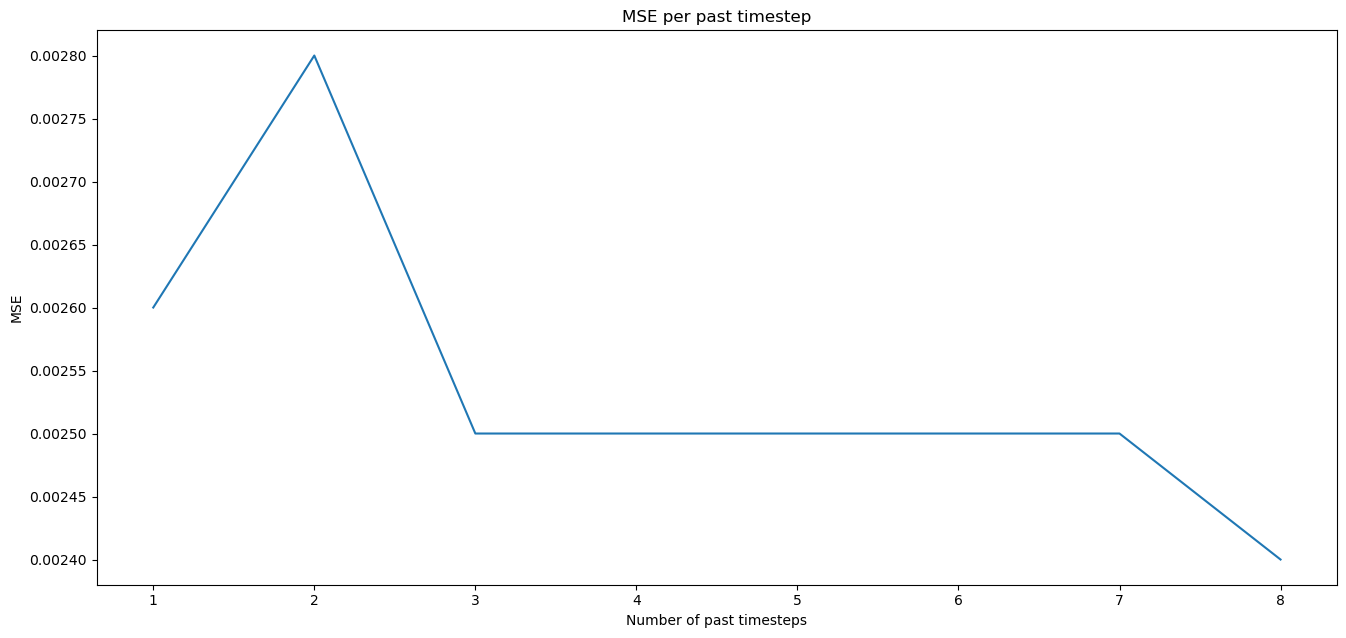

In [15]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,number_of_past_timesteps+1), mse_list)
plt.title('MSE per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('MSE')
plt.show()

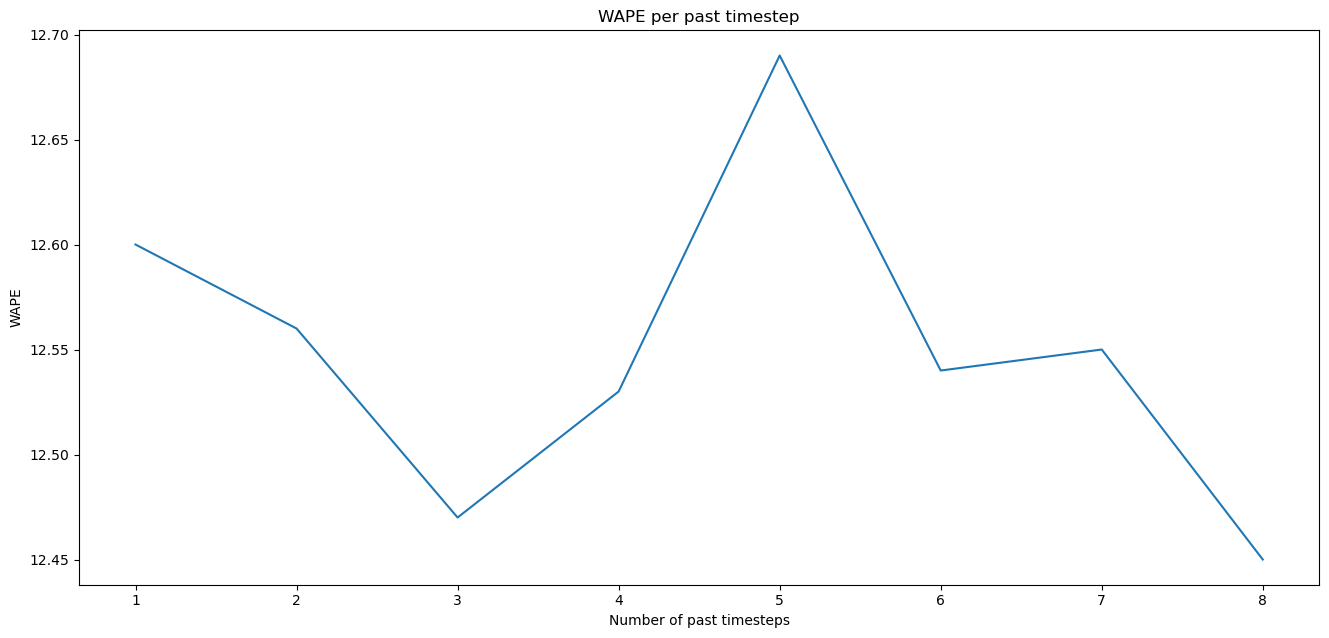

In [16]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,number_of_past_timesteps+1), wape_list)
plt.title('WAPE per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('WAPE')
plt.show()

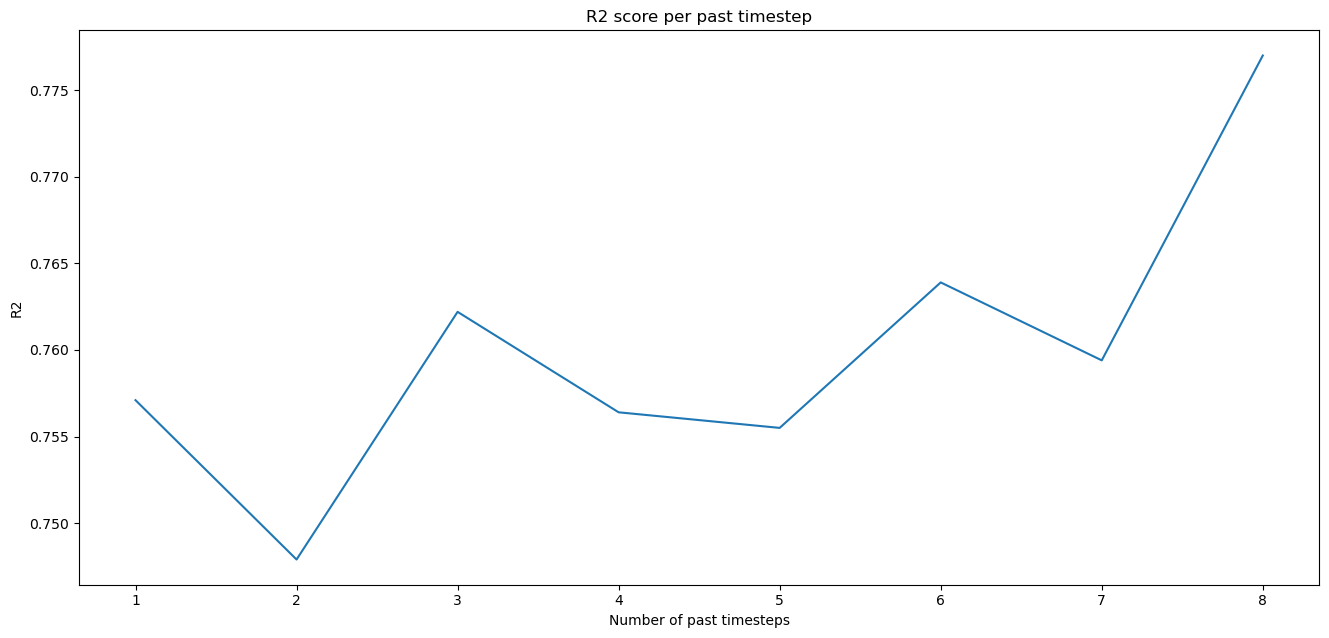

In [17]:
plt.figure(figsize=(16, 7.2))
plt.plot(range(1,number_of_past_timesteps+1), r2_list)
plt.title('R2 score per past timestep')
plt.xlabel('Number of past timesteps')
plt.ylabel('R2')
plt.show()

# Polynomial Regression

### Test for last 8 energy points (2 hours) degree 2, 3 and 4

In [18]:
degree_list = []
full_start = time.time()
for degree in range(2,5):
    metrics_list = []
    print("\n\t\tDegree ", degree)
    for i in range(1,number_of_past_timesteps+1):
        start = time.time()
        print("\nIteration ", i)
        X, y = last_energy_points(df_total, i)
        X_train, X_test, y_train, y_test = prepare_polynomial(X, y, deg=degree)
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
        X_train_norm, scaler = normalize_training(X_train)
        X_test_norm = scaler.transform(X_test)
        y_train_norm, scaler2 = normalize_training(y_train)
        y_test_norm = pd.DataFrame(scaler2.transform(y_test))
        
        mse, wape, r2 = predict_results(X_train_norm, X_test_norm, y_train_norm, y_test_norm, LinearRegression())
        print()
        metrics_list.append((mse,wape,r2))      
        print("\nElapsed time: %.3f seconds" % (time.time() - start))
    degree_list.append(metrics_list)
print("\nFull Elapsed time: %.3f seconds" % (time.time() - full_start))


		Degree  2

Iteration  1
(30414, 2) (7604, 2) (30414, 1) (7604, 1)
MSE: 0.0026
RMSE: 0.0513
WAPE: 12.54
R2: 0.7596


Elapsed time: 0.016 seconds

Iteration  2
(30413, 5) (7604, 5) (30413, 1) (7604, 1)
MSE: 0.0024
RMSE: 0.0494
WAPE: 12.16
R2: 0.7603


Elapsed time: 0.013 seconds

Iteration  3
(30412, 9) (7604, 9) (30412, 1) (7604, 1)
MSE: 0.0026
RMSE: 0.0515
WAPE: 12.59
R2: 0.7542


Elapsed time: 0.022 seconds

Iteration  4
(30412, 14) (7603, 14) (30412, 1) (7603, 1)
MSE: 0.0025
RMSE: 0.0502
WAPE: 12.30
R2: 0.7695


Elapsed time: 0.025 seconds

Iteration  5
(30411, 20) (7603, 20) (30411, 1) (7603, 1)
MSE: 0.0023
RMSE: 0.0489
WAPE: 12.44
R2: 0.7806


Elapsed time: 0.036 seconds

Iteration  6
(30410, 27) (7603, 27) (30410, 1) (7603, 1)
MSE: 0.0023
RMSE: 0.0487
WAPE: 12.40
R2: 0.7777


Elapsed time: 0.035 seconds

Iteration  7
(30409, 35) (7603, 35) (30409, 1) (7603, 1)
MSE: 0.0024
RMSE: 0.0493
WAPE: 12.48
R2: 0.7716


Elapsed time: 0.063 seconds

Iteration  8
(30408, 44) (7603, 44) (304

In [19]:
p_mse_list = []
p_wape_list = []
p_r2_list = []

for j in range(0,3):
    mse_l = []
    wape_l = []
    r2_l = []
    
    for i in range(0,number_of_past_timesteps):
        mse_l.append(degree_list[j][i][0])
        wape_l.append(degree_list[j][i][1])
        r2_l.append(degree_list[j][i][2])
    p_mse_list.append(mse_l)
    p_wape_list.append(wape_l)
    p_r2_list.append(r2_l)

## Comparison between Linear and Polynomial

Text(0, 0.5, 'MSE')

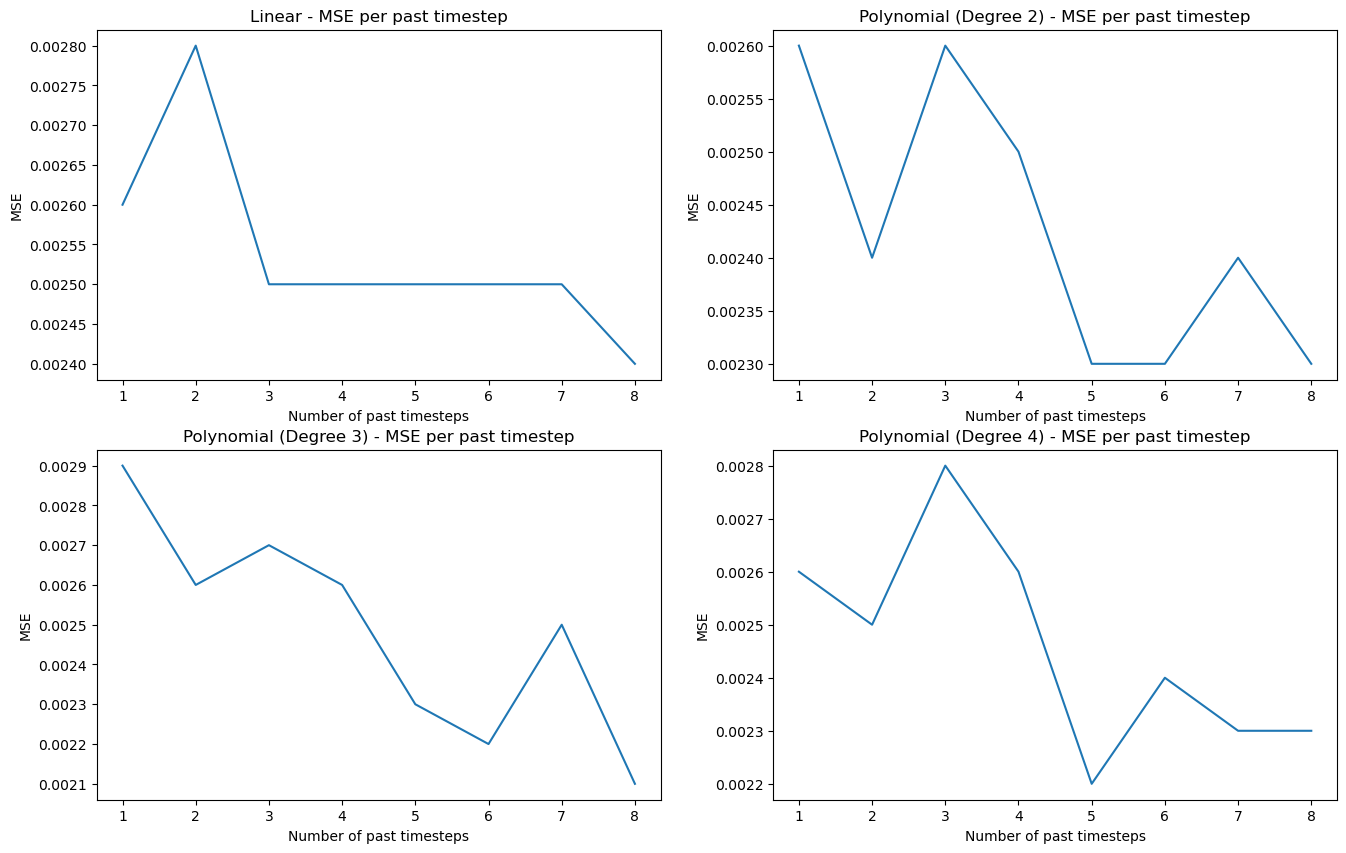

In [20]:
figure, axis = plt.subplots(2, 2, figsize=(16,10))
axis[0,0].plot(range(1,number_of_past_timesteps+1), mse_list)
axis[0,0].set_title("Linear - MSE per past timestep")
axis[0,0].set_xlabel("Number of past timesteps")
axis[0,0].set_ylabel("MSE")
  
axis[0,1].plot(range(1,number_of_past_timesteps+1), p_mse_list[0])
axis[0,1].set_title("Polynomial (Degree 2) - MSE per past timestep")
axis[0,1].set_xlabel("Number of past timesteps")
axis[0,1].set_ylabel("MSE")

axis[1,0].plot(range(1,number_of_past_timesteps+1), p_mse_list[1])
axis[1,0].set_title("Polynomial (Degree 3) - MSE per past timestep")
axis[1,0].set_xlabel("Number of past timesteps")
axis[1,0].set_ylabel("MSE")

axis[1,1].plot(range(1,number_of_past_timesteps+1), p_mse_list[2])
axis[1,1].set_title("Polynomial (Degree 4) - MSE per past timestep")
axis[1,1].set_xlabel("Number of past timesteps")
axis[1,1].set_ylabel("MSE")

Text(0, 0.5, 'WAPE')

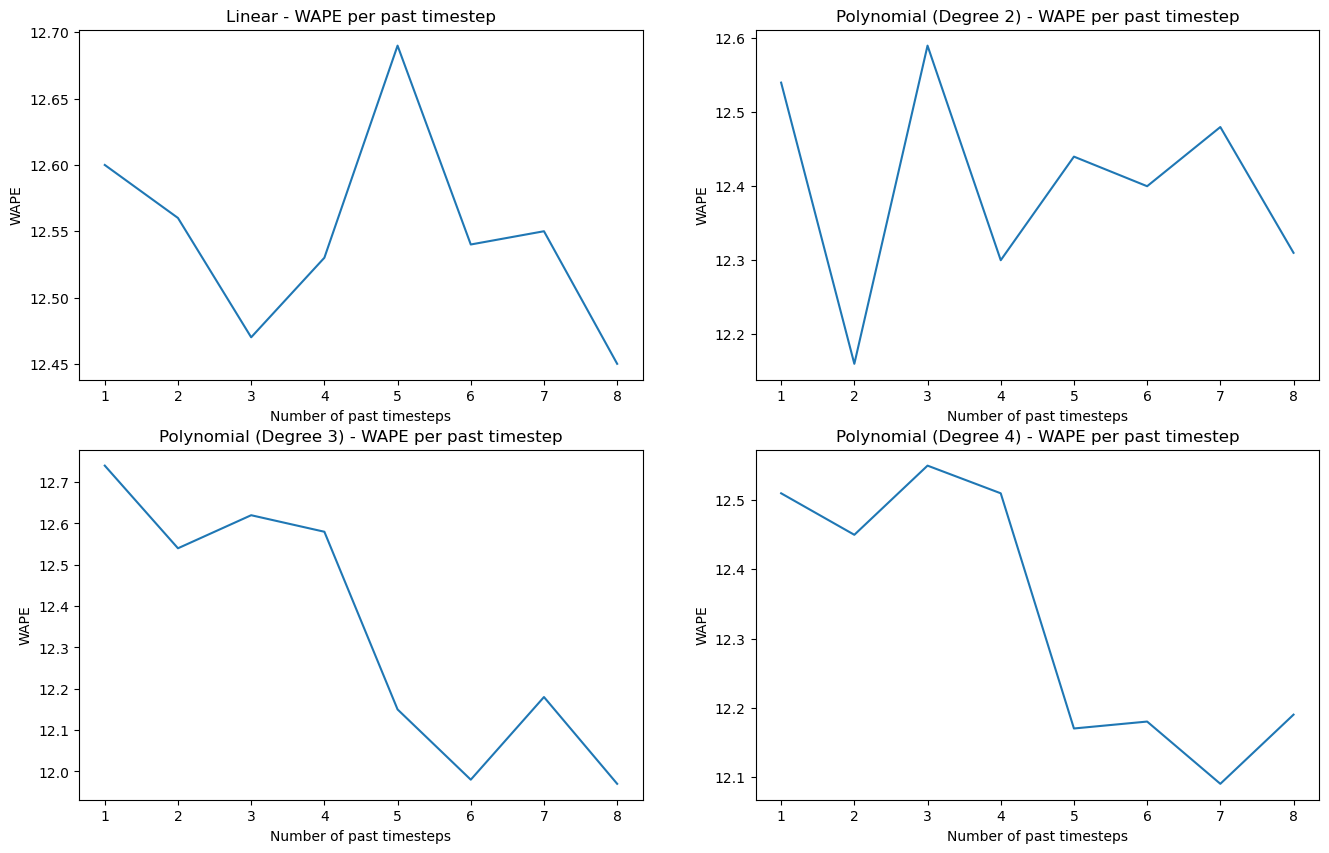

In [21]:
figure, axis = plt.subplots(2, 2, figsize=(16,10))
axis[0,0].plot(range(1,number_of_past_timesteps+1), wape_list)
axis[0,0].set_title("Linear - WAPE per past timestep")
axis[0,0].set_xlabel("Number of past timesteps")
axis[0,0].set_ylabel("WAPE")
  
axis[0,1].plot(range(1,number_of_past_timesteps+1), p_wape_list[0])
axis[0,1].set_title("Polynomial (Degree 2) - WAPE per past timestep")
axis[0,1].set_xlabel("Number of past timesteps")
axis[0,1].set_ylabel("WAPE")

axis[1,0].plot(range(1,number_of_past_timesteps+1), p_wape_list[1])
axis[1,0].set_title("Polynomial (Degree 3) - WAPE per past timestep")
axis[1,0].set_xlabel("Number of past timesteps")
axis[1,0].set_ylabel("WAPE")

axis[1,1].plot(range(1,number_of_past_timesteps+1), p_wape_list[2])
axis[1,1].set_title("Polynomial (Degree 4) - WAPE per past timestep")
axis[1,1].set_xlabel("Number of past timesteps")
axis[1,1].set_ylabel("WAPE")

Text(0, 0.5, 'R2 score')

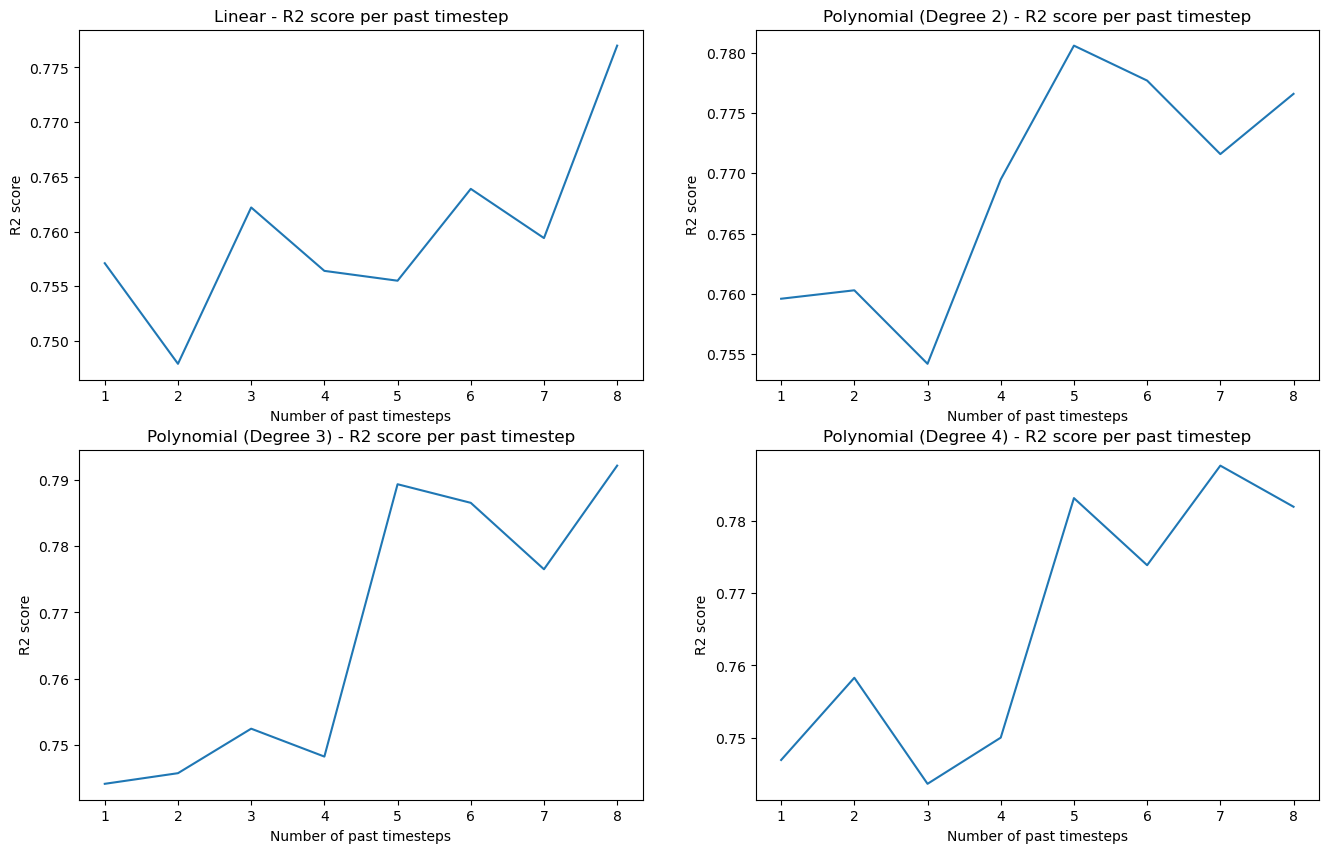

In [22]:
figure, axis = plt.subplots(2, 2, figsize=(16,10))
axis[0,0].plot(range(1,number_of_past_timesteps+1), r2_list)
axis[0,0].set_title("Linear - R2 score per past timestep")
axis[0,0].set_xlabel("Number of past timesteps")
axis[0,0].set_ylabel("R2 score")
  
axis[0,1].plot(range(1,number_of_past_timesteps+1), p_r2_list[0])
axis[0,1].set_title("Polynomial (Degree 2) - R2 score per past timestep")
axis[0,1].set_xlabel("Number of past timesteps")
axis[0,1].set_ylabel("R2 score")

axis[1,0].plot(range(1,number_of_past_timesteps+1), p_r2_list[1])
axis[1,0].set_title("Polynomial (Degree 3) - R2 score per past timestep")
axis[1,0].set_xlabel("Number of past timesteps")
axis[1,0].set_ylabel("R2 score")

axis[1,1].plot(range(1,number_of_past_timesteps+1), p_r2_list[2])
axis[1,1].set_title("Polynomial (Degree 4) - R2 score per past timestep")
axis[1,1].set_xlabel("Number of past timesteps")
axis[1,1].set_ylabel("R2 score")